# Tutorial 3.3: Receiver-Operating Characteristic of a Noisy Neuron

## Neuroscience goal:
- practice in how a neuron's distirbution of spike counts and the ROC curve depends on noise level, stimulus duration, stimulus-responsiveness

## Computational goal:
- manipulation and comparison of distributions of data

### Overview
- assume a neuron receives on type of input current when a stimulus is present and a second type of input current in stimulus absence
- two types of input current can differ in mean value and/or standard deviation
- assume number of spikes over a certain time interval can be detected and used to indicate presence or absence of stimulus
- assess how well two cases are distinguished by setting differnt values of threshold for stimulus detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

- for all questions, simulate AELIF neuron, following dynamics decribed in 1.3 Q2, using parameters defined in `reset_params()` function

In [2]:
def reset_params():
    """
    reset global parameters and initialize variables for simulation
    """
    global e_leak, v_threshold, v_reset, delta_th, g_leak, c_membrane, a, b, tau_sra, v_peak, r_membrane, sigma

    # Define parameters
    e_leak = -70e-3           # Leak potential, mV
    v_threshold = -50e-3      # Spike threshold, mV
    v_reset = -80e-3          # Reset potential, mV
    delta_th = 2e-3           # Threshold decay, mV
    g_leak = 10e-9            # Leak conductance, S
    c_membrane = 100e-12      # Membrane capacitance, F
    r_membrane = 100e6        # Membrane resistance, Ohm
    a = 2e-9                  # I_SRA control term, S
    b = 0                     # I_SRA current step, A
    tau_sra = 150e-3          # SRA time-constant
    v_peak = 40e-3            # Spike uptick, mV
    sigma = 50e-12            # noise term?

reset_params()    
    

### 1. 
- set mean input current in trials with no stimulus to be 0 and in trials with stimulus present to be 0.1nA
- for each timestep, add a random number taken from normal distribution of zero mean and standard deviation of sigma/sqrt(dt), where dt = 0.01ms and sigma = 20pA in both conditions


In [3]:
# set up time vector
dt = 0.01e-3
t = np.arange(0, 0.5, dt)
# noise term
sigma = 20e-12
n_trials = 1000

# set up conditions
spikes_nostim = np.zeros(n_trials)
spikes_stim = np.zeros(n_trials)

def get_currents():
    """resets current vectors for both conditions"""
    global i_app_nostim, i_app_stim

    i_app_nostim = np.random.normal(0, sigma/(np.sqrt(dt)), len(t))
    i_app_stim = np.random.normal(0, sigma/(np.sqrt(dt)), len(t)) + 0.1e-9

In [4]:
def run_aelif(i_app, sigma=0):
    
    v_sim = np.zeros_like(t)
    v_sim[0] = e_leak
    i_sra = np.zeros_like(t)
    i_sra[0] = 0
    spike_times = np.zeros_like(t)
    
    for i in range(1, t.shape[0]):
        # new noise term each simulation
        noise = np.random.rand() * sigma * np.sqrt(dt)
        
        # membrane potential ODE
        dvdt = (g_leak*((e_leak - v_sim[i - 1]) + delta_th * np.exp((v_sim[i - 1] - v_threshold)/delta_th)) - i_sra[i - 1] + i_app[i]) / c_membrane
        # forward Euler update
        v_sim[i] = v_sim[i - 1] + (dt * dvdt) + noise
        
        # SRA current ODE
        didt = ((a * (v_sim[i - 1] - e_leak)) - i_sra[i - 1]) / tau_sra
        # forward Euler update
        i_sra[i] = i_sra[i - 1] + (dt * didt) + noise
        
        if v_sim[i] > v_threshold:
            v_sim[i] = v_reset
            i_sra[i] = i_sra[i] + b
            v_sim[i - 1] = v_peak
            spike_times[i] = 1
            
    return v_sim, spike_times

### *a. simulate each condition for 1000 trials of duration 0.5s*

### *b. count and store number of spikes in each trial of each condition*

In [5]:
for i in range(n_trials):
    
    reset_params()
    get_currents()
    # simulate no stim
    v_sim, spikes = run_aelif(i_app_nostim)
    spikes_nostim[i] = np.sum(spikes)
    
    # simulate w stim
    v_sim, spikes = run_aelif(i_app_stim)
    spikes_stim[i] = np.sum(spikes)

### *c. calculate mean firing rate of each condition*

In [6]:
mean_firing_rate_nostim = np.mean(spikes_nostim / 0.5)
mean_firing_rate_stim = np.mean(spikes_stim / 0.5)

print(f'with no stimulus, mean firing rate over 0.5s is {mean_firing_rate_nostim}Hz')
print(f'with stimulus, mean firing rate over 0.5s is {mean_firing_rate_stim}Hz')

with no stimulus, mean firing rate over 0.5s is 84.648Hz
with stimulus, mean firing rate over 0.5s is 104.282Hz


In [7]:
max_firing_rate_nostim = np.max(spikes_nostim / 0.5)
max_firing_rate_stim = np.max(spikes_stim / 0.5)

print(f'with no stimulus, max firing rate over 0.5s is {max_firing_rate_nostim}Hz')
print(f'with stimulus, max firing rate over 0.5s is {max_firing_rate_stim}Hz')

with no stimulus, max firing rate over 0.5s is 134.0Hz
with stimulus, max firing rate over 0.5s is 148.0Hz


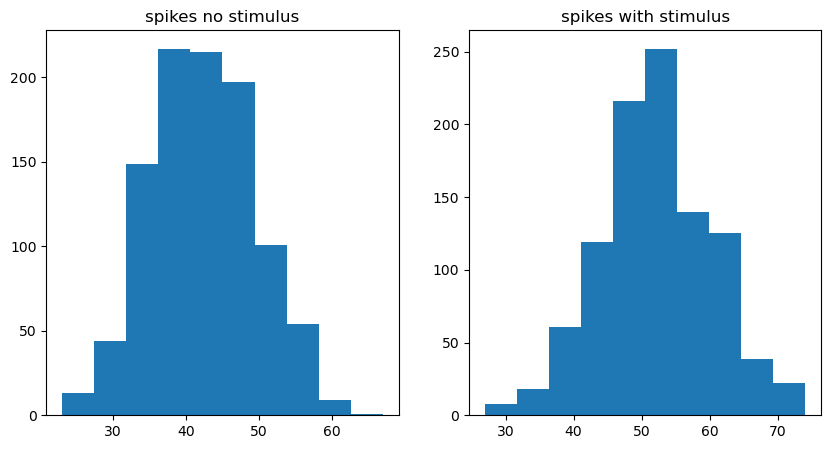

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].hist(spikes_nostim)
ax[0].set_title('spikes no stimulus')

ax[1].hist(spikes_stim)
ax[1].set_title('spikes with stimulus')
plt.show()

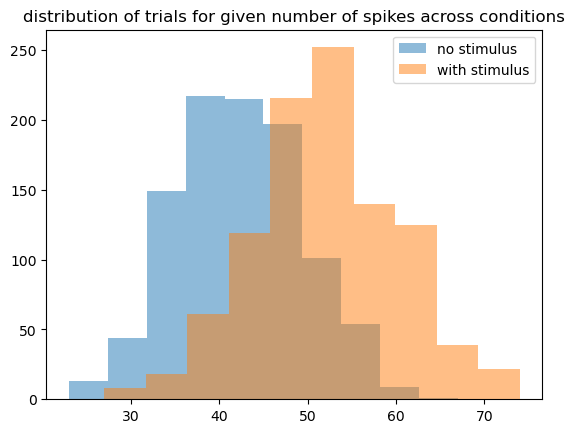

In [9]:
plt.hist(spikes_nostim, alpha=0.5, label='no stimulus')
plt.hist(spikes_stim, alpha=0.5, label='with stimulus')
plt.title('distribution of trials for given number of spikes across conditions')
plt.legend()
plt.show()

### d. count number of trials with a given number of spikes in each condition separately
- to produce identically sized vectors for both conditions, use a range from 0 to max number of spikes found in a trial in either conditoin for the possible values of number of spikes per trial

In [10]:
nmax = max(max(spikes_stim), max(spikes_nostim))
edges = np.arange(0, nmax+1, 1)

hist_nostim, _ = np.histogram(spikes_nostim, edges)
hist_stim, _ = np.histogram(spikes_stim, edges)

### e. plot histogram of number of spikes per trial for each condition

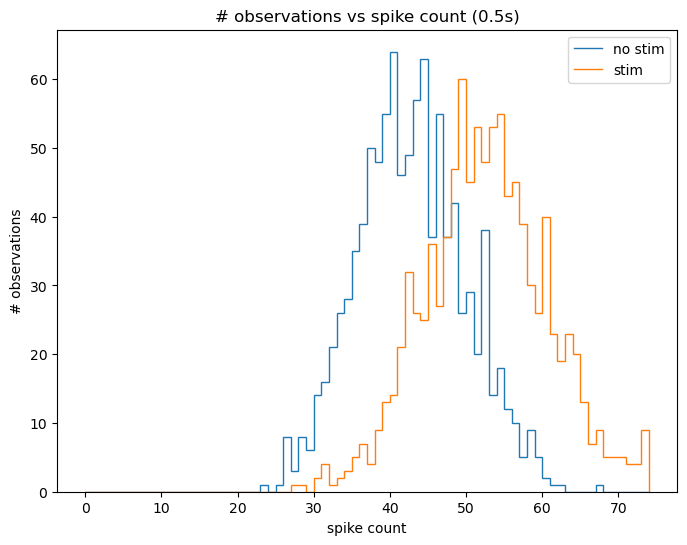

In [11]:
fig, ax = plt.subplots(figsize=(8,6))


ax.stairs(hist_nostim)
ax.stairs(hist_stim)
ax.set_title('# observations vs spike count (0.5s)')
ax.set_xlabel('spike count')
ax.set_ylabel('# observations')
ax.legend(['no stim', 'stim'])

plt.show()

### f. calculate fraction of trials with greater than a given spike count
- using cumsum of histograms
- normalizing by total number of trials and subtracting from one
    - or instead can use command `np.cumsum(histogram_ouput[::-1])[::-1]
- plot monotonically decreasing fraction for each condition

Text(0.5, 0, 'n spikes')

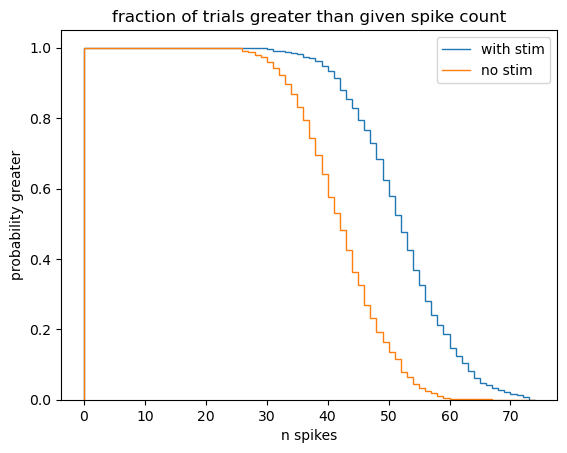

In [16]:
sum_stim = np.cumsum(hist_stim) / n_trials
sum_nostim = np.cumsum(hist_nostim) / n_trials

plt.stairs(1-sum_stim, label='with stim')
plt.stairs(1-sum_nostim, label='no stim')
plt.legend()
plt.title('fraction of trials greater than given spike count')
plt.ylabel('probability greater')
plt.xlabel('n spikes')

### g. plot receiver-operating characteristic curve

- for each value of spike count as a threshold:
    - plot fraction of trials with greater than that spike count in stimulus-on condition as 'true positives' on y-axis,
    - against fraction of trials with greater than that spike count in the stimulus-off condition as 'false positives' on x-axis

In [21]:
n_spikes = np.arange(0, nmax+1)
true_positives = np.zeros(len(n_spikes))
false_positives = np.zeros(len(n_spikes))

for n in range(len(n_spikes)):
    
    true_positives[n] = np.sum(spikes_stim > n_spikes[n]) / n_trials
    false_positives[n] = np.sum(spikes_nostim > n_spikes[n]) / n_trials

Text(0, 0.5, 'P(true positive)')

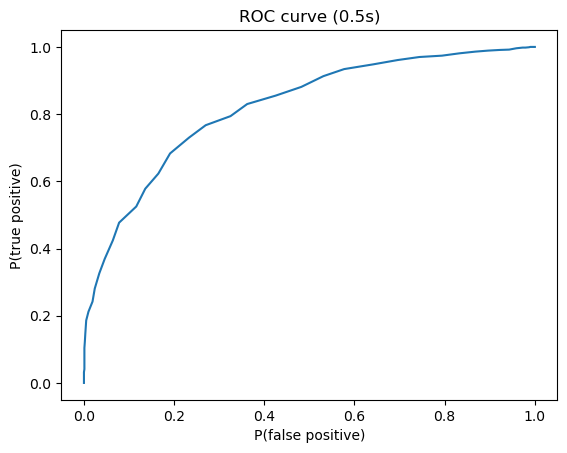

In [22]:
fig, ax = plt.subplots()

ax.plot(false_positives, true_positives)
ax.set_title('ROC curve (0.5s)')
ax.set_xlabel('P(false positive)')
ax.set_ylabel('P(true positive)')

## 2. repeat q1 with stimulus duration of 0.2s instead of 0.5s
- for each of the three figures, explain differences observed vs q1